In [2]:
import numpy as np
import pandas as pd
import pickle
import cv2
import glob
import os

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import cam_cal   as cal
import cv_transf as cvt
import pipeline  as pl
import tracker   as tr

In [3]:
def get_original(dirname, file_names, idx=-1):
    # digit unique identifies a particular image 
    sample = idx if idx != -1 else np.random.randint(len(fnames))
    fname = file_names[sample]
    digit = "".join([ch for ch in fname if ch.isdigit()])    
    return fname, digit
    
def get_filename(dirname, digit, prefix):
    dirname = "_".join([dirname, 'tracked'])
    fname   = "".join([prefix, digit, '.jpg'])
    fname   = os.path.join(dirname, fname)
    return fname

dirname = 'test_images'
pattern = 'test'
ext     = '.jpg'
fnames  = glob.glob(os.path.join(dirname, 'test*.jpg'))

## Camera Calibration

In [4]:
# retrieve chessboard object point(3D) image point(2D) transformation to be used for camera calibration
img_points, obj_points, file_names = \
cal.camera_chessboard('camera_cal', 'calibration', '.jpg', nx=9, ny=6)
# calibrate camera
img = mpimg.imread(file_names[0][0])
img_size = (img.shape[::-1])[:2]
mtx, dist_coef = cal.camera_calibrate(img_points, obj_points, img_size)
# serialize camera matrix(mtx), distortion coefficients to disk
if not os.path.exists('./ckpts'): os.makedirs('./ckpts')
with open('./ckpts/calibration.p', 'wb') as f:
    pickle.dump({'mtx': mtx, 'dist_coef': dist_coef}, f)
# get already serialized calibration matrix
with open('./ckpts/calibration.p', 'rb') as f:
    data_dict = pickle.load(f)
    mtx  = data_dict['mtx']
    dist = data_dict['dist_coef']
    del data_dict

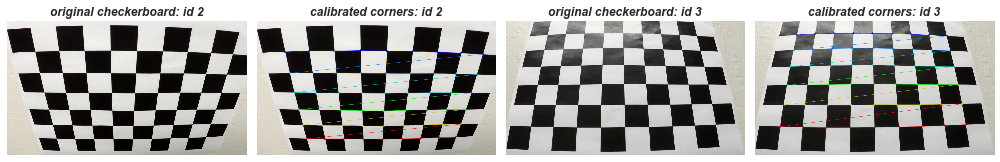

In [6]:
def set_axi_opts(axi, **kwargs):
    axi.grid(False)
    axi.get_yaxis().set_visible(False)
    axi.get_xaxis().set_ticks([])
    fontsize=12
    if 'fontsize' in kwargs: fontsize=kwargs['fontsize']
    params = {'fontweight':'bold', 'fontstyle':'italic', 'fontsize': fontsize}
    if 'title'  in kwargs: axi.set_title(kwargs['title'], **params)
    if 'xlabel' in kwargs: axi.set_xlabel(kwargs['xlabel'], **params)
        
def view_chessboard_pattern(ax1, ax2, img_idx):
    fname = 'camera_cal/calibration{}.jpg'.format(str(img_idx))
    fname_corner = 'camera_cal_corners/cal_corners{}.jpg'.format(str(img_idx))
    ax1.imshow(mpimg.imread(fname))
    set_axi_opts(ax1, **{'title': 'original checkerboard: id {}'.format(str(img_idx))})
    ax2.imshow(mpimg.imread(fname_corner))
    set_axi_opts(ax2, **{'title': 'calibrated corners: id {}'.format(str(img_idx))})

# show chessboard pattern calibration
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(14,8))
view_chessboard_pattern(ax1, ax2, 2)
view_chessboard_pattern(ax3, ax4, 3)
plt.tight_layout()
fig.savefig('./output_images/calibration.png', transparent=False, bbox_inches='tight')

## Gradient Thresholding
- Comparing the different thresholding techniques on a sample image 

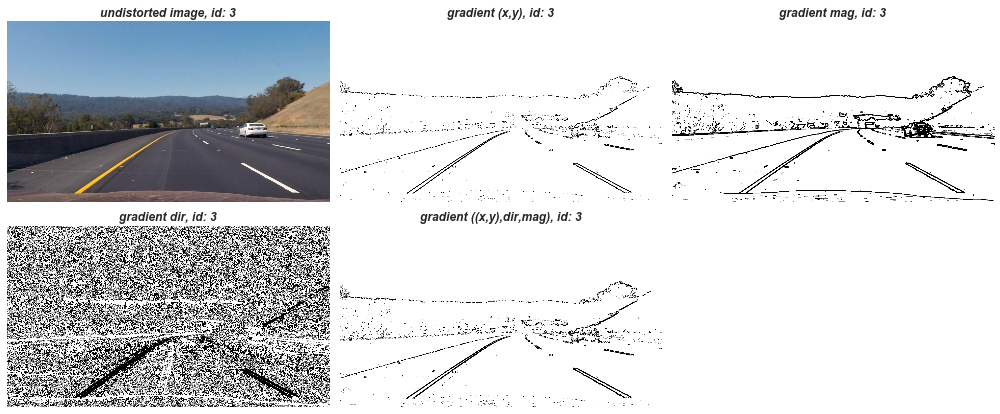

In [8]:
fig, ax = plt.subplots(2,3, figsize=(14,6))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
fname, digit = get_original(dirname, fnames, idx=2)
# raw image
base_img = mpimg.imread(fname)
rows, cols = base_img.shape[:2]
# undistorted image
undist_img = cv2.undistort(base_img, mtx, dist, None, mtx)
ax1.imshow(undist_img)
set_axi_opts(ax1, **{'title': 'undistorted image, id: {}'.format(digit)})
# gradient 
grad_x = cvt.abs_sobel_orient_thresh(undist_img, orient='x', thresh=(12,255))
grad_y = cvt.abs_sobel_orient_thresh(undist_img, orient='y', thresh=(25,255))
p_img  = np.zeros_like(undist_img[:,:, 0])
p_img[( (grad_x == 1) & (grad_y == 1)  )] = 255
ax2.imshow(p_img)
set_axi_opts(ax2, **{'title': 'gradient (x,y), id: {}'.format(digit)})
# magnitude gradient
grad_mag = cvt.mag_sobel_thresh(undist_img, 5, (25,255))
ax3.imshow(grad_mag)
set_axi_opts(ax3, **{'title': 'gradient mag, id: {}'.format(digit)})
# directional gradient
grad_dir = cvt.dir_sobel_thresh(undist_img, 15, (0.7,1.3))
ax4.imshow(grad_dir)
set_axi_opts(ax4, **{'title': 'gradient dir, id: {}'.format(digit)})
# combined gradients
grad_comb = np.zeros_like(grad_dir)
grad_comb[((grad_x == 1) & (grad_y == 1)) | ((grad_mag == 1) & (grad_dir == 1))] = 1
ax5.imshow(grad_comb)
set_axi_opts(ax5, **{'title': 'gradient ((x,y),dir,mag), id: {}'.format(digit)})
fig.delaxes(ax6)
plt.tight_layout()
fig.savefig('./output_images/gradient_exploration.png', transparent=False, bbox_inches='tight')

## Color Thresholding
- Comparing the different color thresholding on an undistorted image

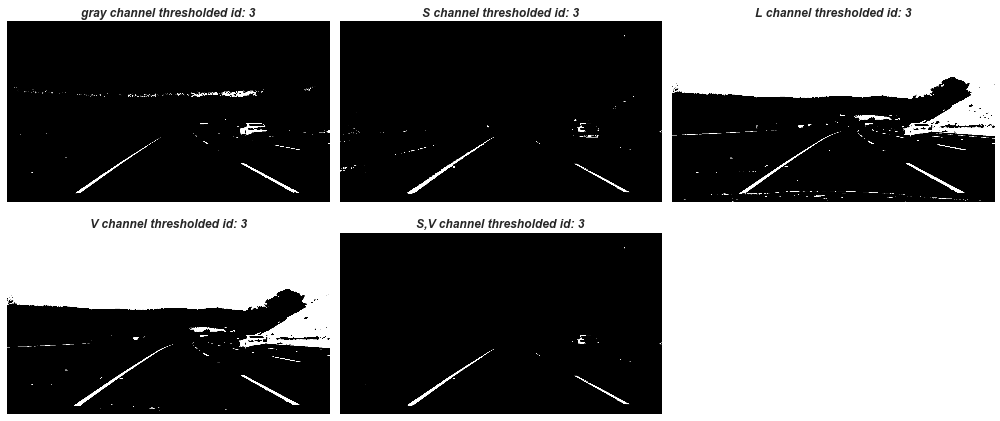

In [9]:
def show_channel_thresholded(channel, threshold, fmt, axi):
    channel_binary = cvt.channel_threshold(channel, thresh=threshold)
    axi.imshow(channel_binary, cmap='gray')
    set_axi_opts(axi, **{'title': '{} channel thresholded id: {}'.format(*fmt)})
    return channel_binary

fig,ax = plt.subplots(2,3, figsize=(14,6))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
# greyscale 
Gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
Gray_thresh = show_channel_thresholded(Gray, (180,255), ('gray', digit), ax1)
# S channel
hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
show_channel_thresholded(hls[:,:,2], (120,255), ('S', digit), ax2)
# L Channel 
show_channel_thresholded(hls[:,:,1], (125,255), ('L', digit), ax3)
# V channels
hsv = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HSV)
show_channel_thresholded(hsv[:,:,2], (150,255), ('V', digit), ax4)
# S, V channels
S,V = (hls[:,:,2], hsv[:,:,2])
S_binary = cvt.channel_threshold(S, thresh=(120,255))
V_binary = cvt.channel_threshold(V, thresh=(150,255))
color_comb_binary = np.zeros_like(S)
color_comb_binary[(S_binary == 1) & (V_binary == 1)] = 1
ax5.imshow(color_comb_binary, cmap='gray')
set_axi_opts(ax5, **{'title': '{} channel thresholded id: {}'.format("S,V",digit)})

fig.delaxes(ax6)
plt.tight_layout(h_pad=2.5)
fig.savefig('./output_images/color_exploration.png', transparent=False, bbox_inches='tight')

## Combining Gradient and Color Channel Thresholds
- Use the combined color channels and Gradients for the perspective Transform

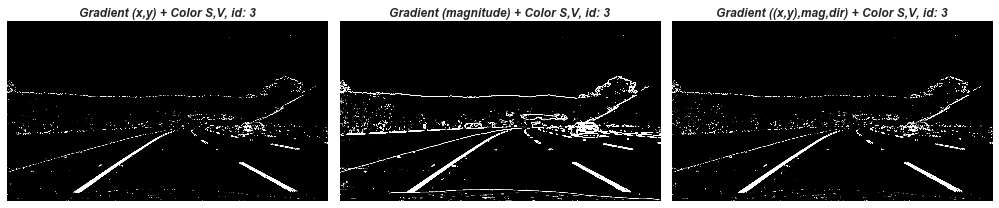

In [10]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(14,8))
# combine grad(x,y), combined colors
p_img  = np.zeros_like(undist_img[:,:, 0])
p_img[( (grad_x == 1) & (grad_y == 1) | (color_comb_binary == 1) )] = 255
ax1.imshow(p_img, cmap='gray')
set_axi_opts(ax1, **{'title': 'Gradient {} + Color {}, id: {}'.format("(x,y)","S,V",digit)})
# combine grad magnitude + color 
p_img  = np.zeros_like(undist_img[:,:, 0])
p_img[( (grad_mag == 1) | (color_comb_binary == 1) )] = 255
ax2.imshow(p_img, cmap='gray')
set_axi_opts(ax2, **{'title': 'Gradient {} + Color {}, id: {}'.format("(magnitude)","S,V",digit)})
# combine grad (mag,(x,y), dir) + color
p_img  = np.zeros_like(undist_img[:,:, 0])
p_img[( (grad_comb == 1) | (color_comb_binary == 1) )] = 255
ax3.imshow(p_img, cmap='gray')
set_axi_opts(ax3, **{'title': 'Gradient {} + Color {}, id: {}'.format("((x,y),mag,dir)","S,V",digit)})
plt.tight_layout()
fig.savefig('./output_images/gradient_color_exploration.png', transparent=False, bbox_inches='tight')

## Perspective Transform Mappings
- Explore source and destination point mappings

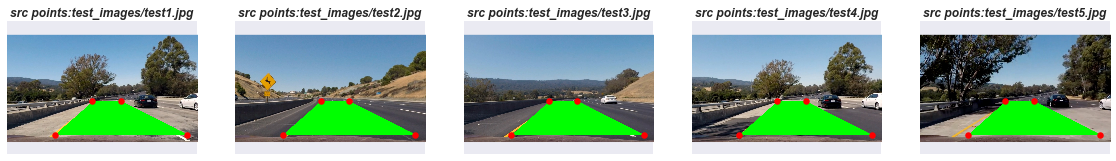

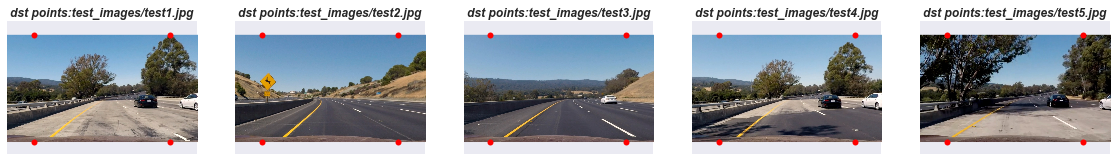

In [53]:
def show_perspective_mappings(img, ax1, ax2):
    src,dst = pl.create_perspective_mappings(img)
    ax1.imshow(img)
    set_axi_opts(ax1, **{'title': 'src points:{}'.format(fname), 'fontsize': 12})
    _ = [ax1.plot(*tup, '.', color='r', markersize=13) for tup in src]
    cp_img = np.copy(img)
    cv2.fillPoly(img, pts=np.int32([src]), color=(0,255,0))
    ax2.imshow(cp_img)
    set_axi_opts(ax2, **{'title': 'dst points:{}'.format(fname), 'fontsize': 12})
    _ = [ax2.plot(*tup, '.', color='r', markersize=12) for tup in dst]

    
fig1, ax1 = plt.subplots(1,5, figsize=(16,6))
plt.tight_layout()
fig2, ax2 = plt.subplots(1,5, figsize=(16,6))
plt.tight_layout()

file_names, digits = zip(*[get_original(dirname, fnames, it) for it in range(5)])
for it, (fname, digit) in zip(range(5), zip(file_names, digits)):
    base_img = mpimg.imread(fname)
    undist_img = cv2.undistort(base_img, mtx, dist, None, mtx)
    axi1, axi2 = (ax1[it], ax2[it])
    show_perspective_mappings(undist_img, axi1, axi2)
fig1.savefig('./output_images/perspective_exploration.png', transparent=False, bbox_inches='tight')    

## Pipeline
Visualize the base pipeline based on explorations from above 
- Undistort Image Using Camera Matrix
- Color/Gradient Threshold
- Apply Region of Interest (ROI) to concentrate on respective lane lines
- Estimate Source and Destination Point Mapping for warped image
- Apply Perspective Transform for warped image per Birds-Eye View

In [12]:
# perform the base pipeline (does include pixel line fit and cuvature)    
pl.pipeline_images(dirname, pattern, ext, method_base=True)

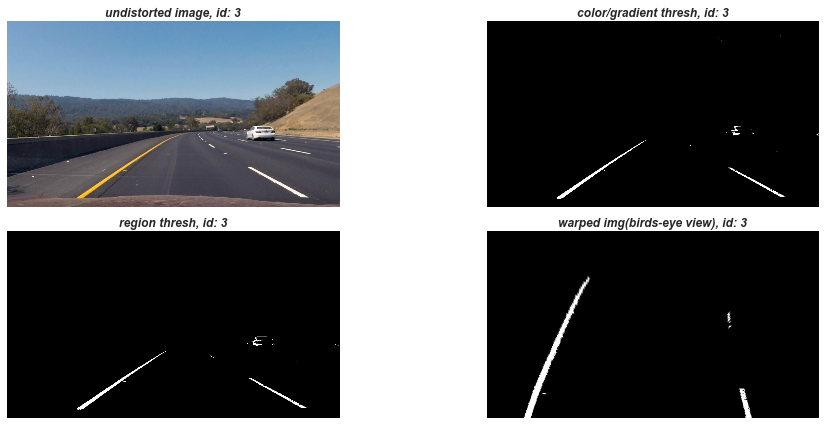

In [32]:
### visualize the base pipeline
fig, ax  = plt.subplots(2,2, figsize=(15,6))
ax1,ax2,ax3,ax4 = ax.flatten()
# undistorted image
digit=str(3)
fname_undist = get_filename(dirname, digit, prefix='tracked_undistorted')
ax1.imshow(mpimg.imread(fname_undist))
set_axi_opts(ax1, **{'title': 'undistorted image, id: {}'.format(digit)})
# gradient/color thresholded binary image
fname_gc = get_filename(dirname, digit, prefix='tracked_gc_binary')
ax2.imshow(mpimg.imread(fname_gc), cmap='gray')
set_axi_opts(ax2, **{'title': 'color/gradient thresh, id: {}'.format(digit)})
# masked region of interest (ROI)
fname_roi = get_filename(dirname, digit, prefix='tracked_roi_binary')
ax3.imshow(mpimg.imread(fname_roi), cmap='gray')
set_axi_opts(ax3, **{'title': 'region thresh, id: {}'.format(digit)})
# perspective transform
fname_warped = get_filename(dirname, digit, prefix='tracked_warped_binary')
ax4.imshow(mpimg.imread(fname_warped), cmap='gray')
set_axi_opts(ax4, **{'title': 'warped img(birds-eye view), id: {}'.format(digit)})
plt.tight_layout()
fig.savefig('./output_images/pipeline_base.png', transparent=False, bbox_inches='tight')

## Associate Pixels to Lines
- Approximate starting baseline for left and right lanes from image via histogram (for comparison purposes)
- Apply Convolution Sliding Window Method instead of Averaging Method

Peaks(x) left: 177, midpoint: 640, right: 996


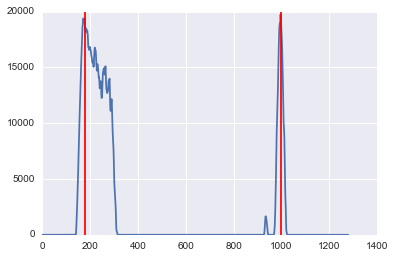

In [35]:
# determine estimated peaks initally before convolution method
warped_img = mpimg.imread(fname_warped)
rows, cols = warped_img.shape[:2]
histogram, leftx_current, rightx_current = tr.find_hist_peaks(warped_img)
plt.plot(histogram)
plt.axvline(x=leftx_current,  color='r')
plt.axvline(x=rightx_current, color='r')

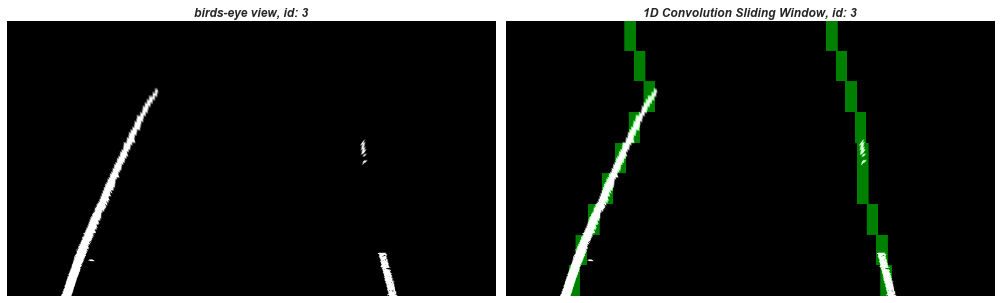

In [52]:
# define configuration for 1D convolution
params = {'window_width':  30,
          'window_height': rows/9,            # rows/n_windows(9)
          'window_margin': 25,
          'ym_per_pix':    10/rows,           # 10m ~ 720 pixels 
          'xm_per_pix':    4/800,             # 4m  ~ 800 pixels
          'smooth_factor': 15,
          'img_dim':       (rows,cols)}
# associate pixels to lines
conv_centers = tr.TrackerConv1D(**params)
window_centroids = conv_centers.find_window_centroids(warped_img)
conv_img = conv_centers.draw_centroids(warped_img, window_centroids)
# compare image pipeline
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.imshow(warped_img, cmap='gray')
set_axi_opts(ax1, **{'title': 'birds-eye view, id: {}'.format(digit)})
ax2.imshow(conv_img)
set_axi_opts(ax2, **{'title': '1D Convolution Sliding Window, id: {}'.format(digit)})
plt.tight_layout()
fig.savefig('./output_images/pipeline_centroids.png', transparent=False, bbox_inches='tight')

## Measure Curvature
- Preconditions: 
    - determined which pixels belong to left and right lane lines via convolution
- Compute Radius of Curvature (should be on order of 1km)
    - http://www.intmath.com/applications-differentiation/8-radius-curvature.php
- Note these methods are applied in the second half of the pipeline as well

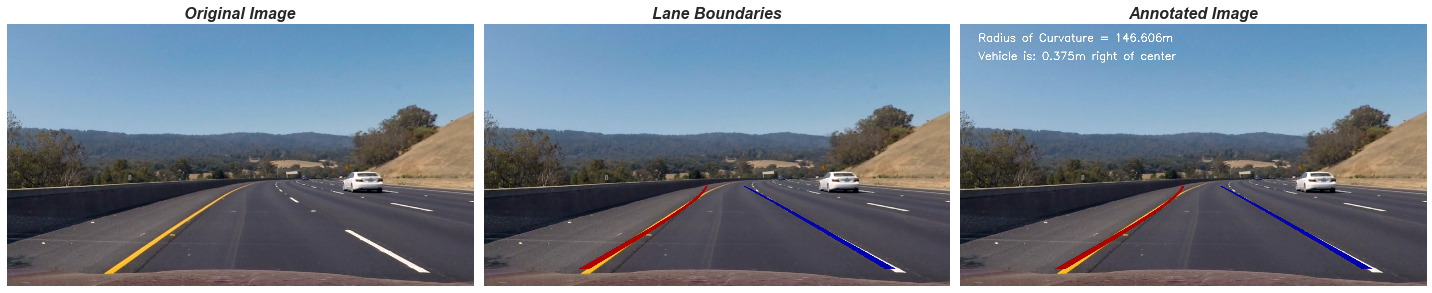

In [51]:
curvature = tr.TrackerCurvature(**params)
left_fitx, right_fitx = curvature.fit_lane_boundaries(window_centroids)
left_lane, right_lane, inner_lane = curvature.fit_lanes(left_fitx, right_fitx)
img = mpimg.imread(fname_undist)
img_lanes = curvature.view_lanes(img, left_lane, right_lane, inner_lane)
img_annot = curvature.annotate_frame(img_lanes, window_centroids, left_fitx, right_fitx)
imgs = (img, img_lanes, img_annot)
titles = ('Original Image', 'Lane Boundaries', 'Annotated Image')

fig, ax = plt.subplots(1,3, figsize=(20,6))
for axi, imgi, title in zip(ax, imgs, titles):
    axi.imshow(imgi)
    set_axi_opts(axi, **{'title': title, 'fontsize': 16})
plt.tight_layout()
fig.savefig('./output_images/pipeline_curvature_annotated.png', transparent=False, bbox_inches='tight')